In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


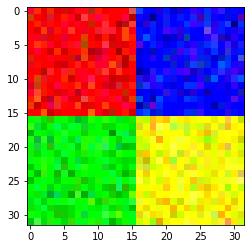

In [68]:
im_dim = 32
image = np.zeros((im_dim,im_dim, 3))
image[:im_dim//2, :im_dim//2] = [1, 0, 0]  # Red
image[:im_dim//2, im_dim//2:] = [0, 0, 1]  # Blue
image[im_dim//2:, :im_dim//2] = [0, 1, 0]  # Green
image[im_dim//2:, im_dim//2:] = [1, 1, 0]  # Yellow

noise = np.random.normal(0, 0.15, image.shape)
image += noise

plt.imshow(image)
plt.show()


/tmp/ipykernel_624441/3354990209.py:45: RuntimeWarning: invalid value encountered in true_divide
  eigenvectors_normalized = eigenvectors / np.linalg.norm(eigenvectors, axis=1)[:, np.newaxis]


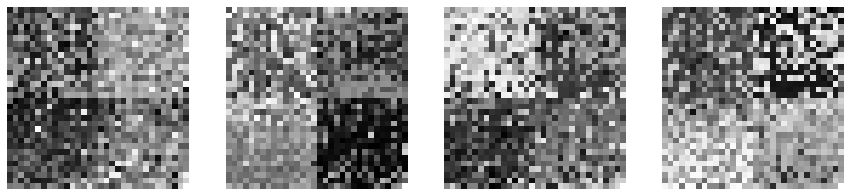

In [69]:
from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

# Hyperparameters for the weight calculation
sigma_I = 0.1  # Assumed value for the intensity difference scaling.
sigma_x = 20.0  # Assumed value for the spatial distance scaling.
r = 15.0  # Assumed radius for the neighborhood.

# Flatten the image to work with it as a graph.
nodes = np.reshape(image, (-1, 3))  # Flatten the image to get a list of nodes.
indices = np.indices(image.shape[:2]).reshape(2, -1).T  # Get the spatial location of each node.

# Calculate the weight matrix.
def compute_weights(nodes, indices, sigma_I, sigma_x, r):
    # Compute the intensity difference weights.
    intensity_weights = np.exp(-cdist(nodes, nodes, 'sqeuclidean') / (2 * sigma_I**2))
    
    # Compute the spatial distance weights.
    spatial_weights = np.exp(-cdist(indices, indices, 'sqeuclidean') / (2 * sigma_x**2))
    
    # Apply the radius threshold.
    spatial_weights[cdist(indices, indices) > r] = 0
    
    # Element-wise multiplication of the two weight matrices.
    weights = np.multiply(intensity_weights, spatial_weights)
    
    # Since the weight matrix is symmetric and the graph is undirected, we only need the upper triangle.
    weights = np.triu(weights)
    return csr_matrix(weights)  # Use a sparse matrix to save memory.

# Compute the weight matrix W.
W = compute_weights(nodes, indices, sigma_I, sigma_x, r)

# Compute the degree matrix D.
D = np.diag(W.sum(axis=1).A1)

# Solve the generalized eigensystem (D - W)y = lambda Dy for the smallest non-zero eigenvalues.
# Since we are looking for a partitioning into 4 segments, we find the first 5 eigenvectors (including the trivial solution).
num_eigenvectors = 5
_, eigenvectors = eigsh(D - W, M=D, which='SM', k=num_eigenvectors)

# Exclude the first eigenvector (trivial solution) and normalize the remaining ones for clustering.
eigenvectors = eigenvectors[:, 1:num_eigenvectors]
eigenvectors_normalized = eigenvectors / np.linalg.norm(eigenvectors, axis=1)[:, np.newaxis]

# Reshape the eigenvectors back to the original image shape for visualization.
eigenvectors_image = eigenvectors_normalized.reshape(image.shape[0], image.shape[1], -1)

# Display the eigenvectors as images for visualization.
fig, axes = plt.subplots(1, num_eigenvectors - 1, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(eigenvectors_image[:, :, i], cmap='gray')
    ax.axis('off')
plt.show()

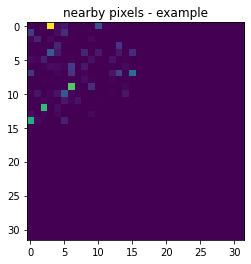

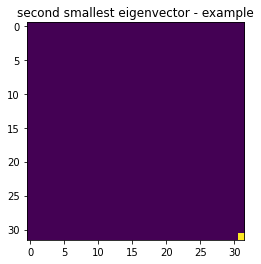

(1024,)


In [70]:
plt.title("nearby pixels - example")
plt.imshow(W[3].todense().reshape(image.shape[:2]))
plt.show()

eigenvectors,small_eigen = second_smallest_eigenvector(W, D)

plt.title("second smallest eigenvector - example")
plt.imshow(small_eigen.reshape(image.shape[:2]))
plt.show()

print(eigenvectors.shape)

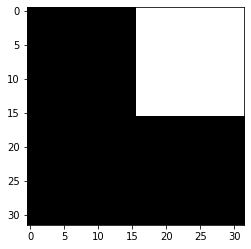

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# Provided utility function by the user
def second_smallest_eigenvector(A, D):
    # get the second smallest eigenvector from affinity matrix
    _, eigenvectors = eigh(D-A, D, subset_by_index=[1,2])
    eigenvec = np.copy(eigenvectors[:, 0])
    second_smallest_vec = eigenvectors[:, 0]
    return eigenvec, second_smallest_vec

# Assumed standard deviation values for the Gaussian.
sigma_I = 0.1  # Standard deviation for intensity.
sigma_x = 20  # Standard deviation for distance.
r = 15  # Cutoff distance for pixels to be considered neighbors.

# Flatten the image array to work with it as a graph.
flat_image = image.reshape(-1, image.shape[-1])

# Compute the pixel intensity distance squared (feature space).
intensity_dist_squared = np.sum((flat_image[:, np.newaxis] - flat_image[np.newaxis, :]) ** 2, axis=2)

# Compute the spatial distance squared (spatial space).
X, Y = np.indices(image.shape[:2])
x_dist_squared = (X.flatten()[:, np.newaxis] - X.flatten()[np.newaxis, :]) ** 2
y_dist_squared = (Y.flatten()[:, np.newaxis] - Y.flatten()[np.newaxis, :]) ** 2
spatial_dist_squared = x_dist_squared + y_dist_squared

# Compute the weight matrix W.
W = np.exp(-intensity_dist_squared / (sigma_I**2)) * np.exp(-spatial_dist_squared / (sigma_x**2))
W[spatial_dist_squared > r**2] = 0  # Apply cutoff radius r.

# Compute the degree matrix D.
D = np.diag(W.sum(axis=1))

# Compute the second smallest eigenvector.
eigenvec, second_smallest_vec = second_smallest_eigenvector(W, D)

plt.imshow(eigenvec.reshape(image.shape[:2]), cmap='gray')

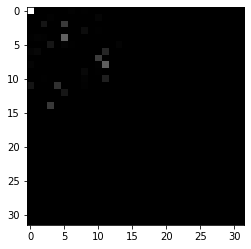

In [72]:
plt.imshow(W[0].reshape(image.shape[:2]), cmap='gray')

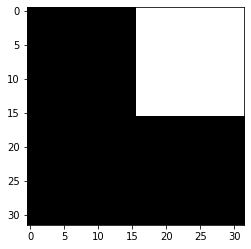

In [76]:
import torch

Wt = torch.from_numpy(W)
Dt = torch.from_numpy(D)
gen_eigenvals, gen_eigenvectors = torch.lobpcg(Dt-Wt, B=Dt,k=5,largest=False)

plt.imshow(gen_eigenvectors[:, 1].reshape(image.shape[:2]), cmap='gray')